In [1]:
!pip install --quiet neural-structured-learning

This is Tensorflow's Neural Structure Learning<br>
https://www.tensorflow.org/neural_structured_learning<br><br>
This is the link with a more in depth look at how it works<br>
https://blog.tensorflow.org/2019/09/introducing-neural-structured-learning.html<br><br>


The basic idea of this library is that it is a new way to train neural networks by using structured signals in conjunction with feature inputs.
Structured signals use graphs to show how samples are related by stating their neighbors and use these realations as input data, where in training 
it is minimizing supervised loss and neighbor loss. This relates to adversarial training since we can creates structures dynamically for input samples
by constructing the structures with adversarial perturbation. <br><br>

This notebook will be following the tutorial provided by Tensorflow.<br>
https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist

In [19]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
sns.set()

In [3]:
# These are the hyper params defined for model training and evaluating
class HParams(object):
  def __init__(self):
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [4]:
# Here we load the MNIST dataset (Goal later on is to adapt this code with other datasets)
datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

Shuffling and writing examples to C:\/Users/alexk/tensorflow_datasets/mnist/3.0.1.incompleteEM48Q9/mnist-train.tfrecord


Shuffling and writing examples to C:\/Users/alexk/tensorflow_datasets/mnist/3.0.1.incompleteEM48Q9/mnist-test.tfrecord


Dataset mnist downloaded and prepared to C:\Users\alexk\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [5]:
# Here we normalize the pixel values to [0, 1]
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

# shuffling training set and batching then converting the examples to feature tuples (image, label) for training the base model
train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

In [6]:
# Creating the base model
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [7]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)              

In [8]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1496 - acc: 0.9538
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0486 - acc: 0.9854
Epoch 3/5
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0357 - acc: 0.9887
Epoch 4/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0275 - acc: 0.9916
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0211 - acc: 0.9931


In [9]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

313/313 [==============================] - 1s 4ms/step - loss: 0.0327 - acc: 0.9906

accuracy: 0.9905999898910522


In [10]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [11]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

In [12]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000182867AD830> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000182867AD830> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000182867AD830> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1875/1875 [==============================] - 36s 19ms/step - loss: 0.2881 - sparse_categorical_crossentropy: 0.1375 - sparse_categorical_accuracy: 0.9590 - scaled_adversarial_loss: 0.1506
Epoch 2/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1111 - sparse_categorical_crossentropy: 0.0421 - sparse_categorical_accuracy: 0.9869 - scaled_adversarial_loss: 0.0690
Epoch 3/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0617 - sparse_categorical_crossentropy: 0.0337 - sparse_categorical_accuracy: 0.9893 - scaled_adversarial_loss: 0.0280
Epoch 4/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0435 - sparse_categorical_crossentropy: 0.0243 - sparse_categorical_accuracy: 0.9925 - scaled_adversarial_loss: 0.0192
Epoch 5/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0472 - sparse_categorical_crossentropy: 0.0214 - sparse_categorical_accuracy: 0.9932 - scaled_adversarial_loss: 0.0258


In [13]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

313/313 [==============================] - 3s 9ms/step - loss: 0.0373 - sparse_categorical_crossentropy: 0.0251 - sparse_categorical_accuracy: 0.9921 - scaled_adversarial_loss: 0.0121

accuracy: 0.9921000003814697


In [14]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [15]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [16]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.532700
adv-regularized model accuracy: 0.930900


accuracy in batch 0:
base model: 17 / 32
adv-regularized model: 30 / 32


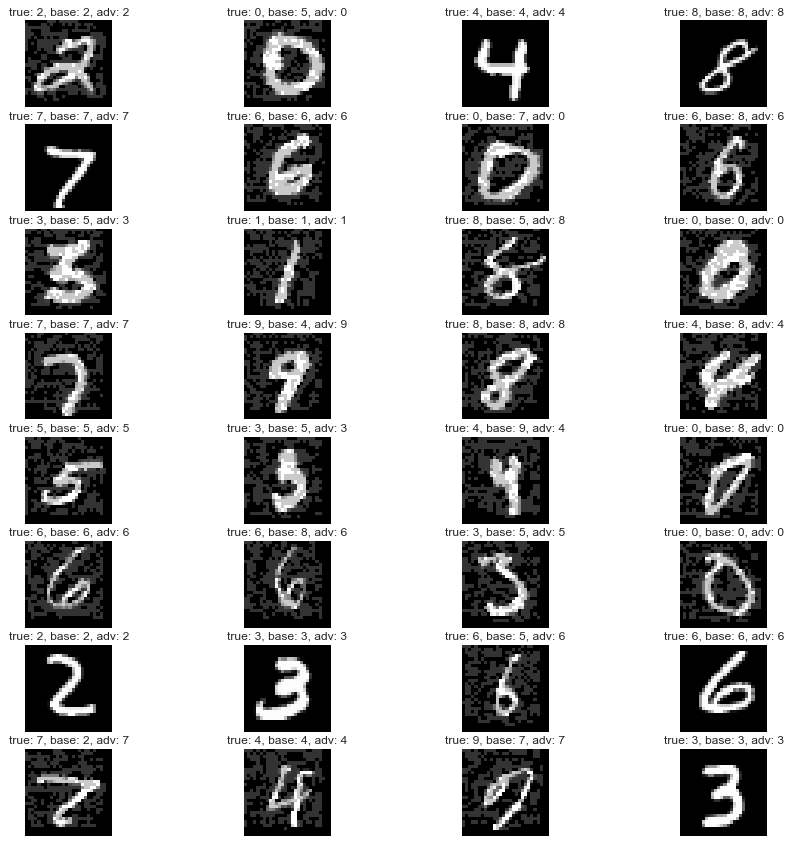

In [20]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()